In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.linear_model import Perceptron
from collections import defaultdict

In [63]:
!pip install kaczmarz-algorithms

# Linear Regression

In [116]:
n = 100
d = 10
X = np.random.randn(n, d)
w_true = np.random.randn(d)
w_true /= np.linalg.norm(w_true)
U, _, _ = np.linalg.svd(X)
print(U.shape)
r = np.random.randn(n)
r -= U @ U.T @ r # get residual that is orthogonal to range(X)
y = X @ w_true + r/np.linalg.norm(r)


wast = np.linalg.lstsq(X, y, rcond=-1)[0]
print(f"w* = {wast}")
print(f"wtrue = {w_true}")

(100, 100)
w* = [ 0.08991282  0.27513783 -0.52163028  0.63621361  0.10466802 -0.10137493
  0.06130745  0.20061396  0.3470001  -0.32336481]
wtrue = [ 0.10847102  0.21450367 -0.51632805  0.62999754  0.09437226 -0.07376377
  0.07511014  0.18062311  0.34556196 -0.32665599]


In [117]:
import kaczmarz 

class InsideOut(kaczmarz.Base):
    def __init__(self, A, wast, *args, **kwargs):
        super().__init__(A, *args, **kwargs)
        self.row_norms2 = np.linalg.norm(self._A, axis=1)**2.
        self.residuals = -self._b
        self.xast_residuals = self._A @ wast - self._b

    def _select_row_index(self, xk):
        self.residuals = self._A @ self._xk - self._b
        vals = 0.5*self.residuals**2. - self.residuals * self.xast_residuals
        self.row_index = np.argmax(vals)
        
        return self.row_index

In [118]:
w0 = np.zeros_like(wast)
iterates = {}

iterates['cyclic'] = list(kaczmarz.Cyclic.iterates(X, y, x0=w0.copy()))
iterates['motzkin'] = list(kaczmarz.MaxDistance.iterates(X, y, x0=w0.copy()))
iterates['iid'] = list(kaczmarz.Random.iterates(X, y, x0=w0.copy()))
iterates['rkm'] = list(kaczmarz.SVRandom.iterates(X, y, x0=w0.copy()))
iterates['io'] = list(InsideOut.iterates(X, b=y, wast=wast.copy(), x0=w0.copy()))

In [119]:
results = {}
for method, its in iterates.items():
    results[method] = {'res': [np.linalg.norm(X @ xk-y) for xk in its],
                        'dist_to_wast' : [np.linalg.norm(xk - wast) for xk in its]}

In [120]:
for method, res in results.items():
    print(method, ", ", res['res'][-1], ", ", res['dist_to_wast'][-1])

cyclic ,  0.8876786671578304 ,  0.050052311931160325
motzkin ,  1.064568913321167 ,  0.07746775768289904
iid ,  1.1016783259700753 ,  0.08101368575381707
rkm ,  1.0194385191039 ,  0.06541520920237073
io ,  0.7559855663124696 ,  0.006710644509871342


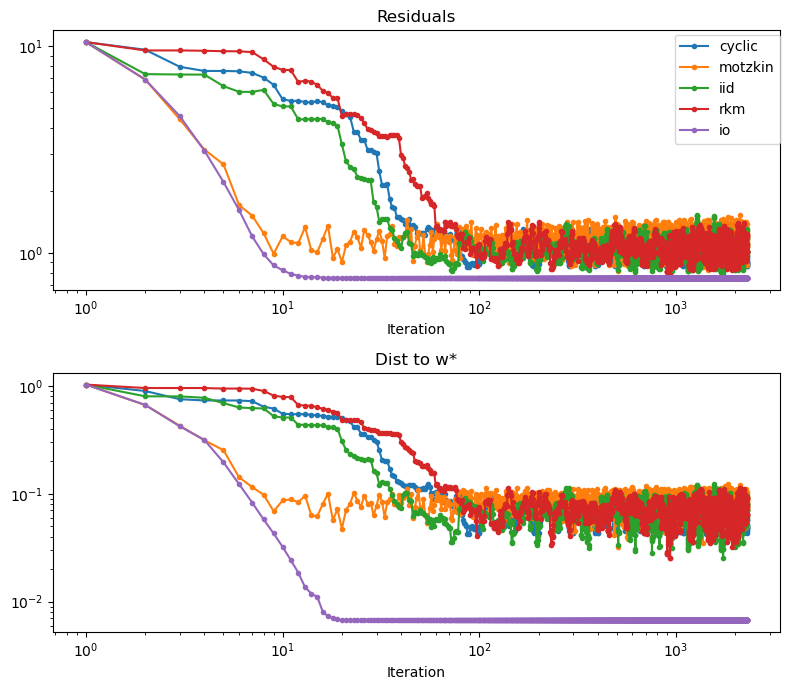

In [123]:
fig, axs = plt.subplots(2, 1, figsize=(8,7))
for method, res in results.items():
    axs[0].loglog(range(1,1+len(res['res'])), res['res'], '.-', linewidth=1.5, label=method)
    axs[1].loglog(range(1,1+len(res['dist_to_wast'])), res['dist_to_wast'], '.-', linewidth=1.5, label=method)
axs[0].legend(bbox_to_anchor=(1.01,1.01))
axs[0].set_title("Residuals")
axs[1].set_title("Dist to w*")

axs[0].set_xlabel("Iteration")
axs[1].set_xlabel("Iteration")
fig.tight_layout()
plt.show()

We see that inside-out sampling is superior in this test setting taken from Deanna Needell's group. Inside Out is more than just Motzkin's method, it uses the oracle to know which "large" residuals need to be corrected first.


# Perceptron

In [468]:
line_types = ['-', '--', '.-', 'o-', '*-', '^-', 's-', 'v-', '>-', '<-']

def plot_acc_angle(results, Wstar_acc, approx=False):
    fig, axs = plt.subplots(2, 1, figsize=(10,8))
    j = 0
    for method, d in results.items():
        num_steps = len(d['results']['acc'])
        is_approx = method.split('-')[0] == 'approx'
        if is_approx == approx:
            axs[0].plot(range(num_steps), d['results']['acc'],  line_types[j], linewidth=1.8, label=method, markevery=5)
            axs[1].plot(range(num_steps), np.arccos(d['results']['ip']),line_types[j],  linewidth=1.8, label=method, markevery=5)
            j += 1
    axs[0].plot(range(num_steps), num_steps*[Wstar_acc], 'k-', label='wstar')
    axs[0].legend()
    axs[0].set_title("Accuracy")
    axs[0].set_xlabel("# of steps")
    axs[1].legend()
    axs[1].set_ylabel("Radians")
    axs[1].set_title("Angle to wstar")
    axs[1].set_xlabel("# of steps")
    fig.tight_layout()
    plt.show()

    
def plot_diff_size(results, Wstar_size, approx=False):
    fig, axs = plt.subplots(2, 1, figsize=(10,8))
    j = 0
    for method, d in results.items():
        num_steps = len(d['results']['delta_wt'])
        is_approx = method.split('-')[0] == 'approx'
        if is_approx == approx:
            axs[0].plot(range(len(d['results']['delta_wt'])), d['results']['delta_wt'],  line_types[j], linewidth=1.8, label=method, markevery=5)
            axs[1].plot(range(len(d['results']['Wt_size'])), d['results']['Wt_size'],line_types[j],  linewidth=1.8, label=method, markevery=5)
            j += 1
    axs[0].legend()
    axs[0].set_title(r"$\|w_{t+1} - w_t\|_2$")
    axs[0].set_xlabel("# of steps")
    axs[1].plot(range(num_steps), num_steps*[Wstar.size], 'k-', label=r'$\mathcal{W}_\ast$')
    axs[1].legend()
    axs[1].set_ylabel("Count")
    axs[1].set_title(r"$|\mathcal{W}_t|$")
    axs[1].set_xlabel("# of steps")
    fig.tight_layout()
    plt.show()
    

In [744]:
n, d = 1000, 30
r = 5.
gamma = 0.01
X = r*(np.random.rand(n+100, d)-0.5)
wstar = 2.*np.random.randn(d)
mask = np.absolute(np.inner(X, wstar)) >= gamma
X = X[mask,:]
print(X.shape)
y = 1*(np.inner(X, wstar) > 0)

(1100, 30)


## Perceptron Sampling

Given dataset $X = \{x_1, \ldots, x_n\} \subset \mathbb{R}^d$ and assume there exists a "true" $w_\ast \in \mathbb{R}^d$ such that the classification $y_i =\mathbb{1}\{x_i \cdot w_\ast > 0\} \in \{0, 1\}$. 

The perceptron training proceeds by only updating the classifier $w_t$ with data pair $x_{i_t}, y_{i_t}$ if it incorrectly classifies $x_{i_t}$. That is, with learning rate $r > 0$ and classifier $f_t(x) = \mathbb{1}\{x\cdot w_t > 0\}$, we write
$$
\begin{align*}
    w_{t+1} &= w_{t} + r\begin{cases}
        (y_{i_t}-f_t(x_{i_t}) x_{i_t} & \text{ if } y_{i_t} \not= f_t(x_{i_t}) \\
        0 & \text{o.w.}
    \end{cases} \\
    &= w_{t} + \begin{cases}
        r(-1)^{y_{i_t}} x_{i_t} & \text{ if } y_{i_t} \not= f_t(x_{i_t}) \\
        0 & \text{o.w.}
    \end{cases}
\end{align*}
$$

Define $\mathcal{W}_t \equiv \{ x_i \in X : f_t(x_i) \not= y_i\}$.
Consider a pair $x_i, y_i$, then the updated inner product can be written as 
$$
\begin{align*}
    w_{t+1}\cdot w_\ast &= w_{t}\cdot w_\ast - r  (-1)^{y_i} (x_i \cdot w_\ast)  \\
    &= w_{t}\cdot w_\ast + r |x_i \cdot w_\ast| 
\end{align*}
$$
Thus, in order to maximize this last equation, we'd like to choose 
$$
x_i, y_i = argmax_{x, y \in \mathcal{W}_t} \ |x \cdot w_\ast|  \},
$$
or in words, the point that the current classifier gets wrong, but is farthest from the true margin than any other incorrectly classified point.

1.0


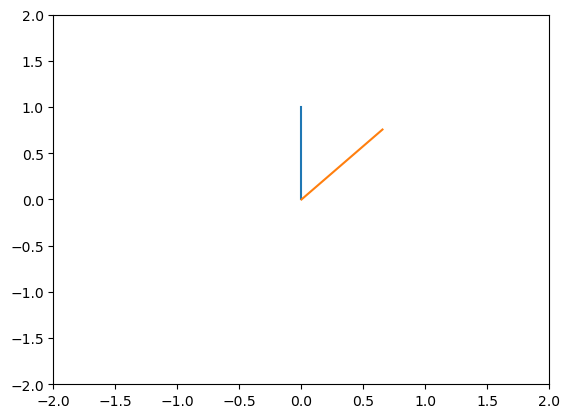

In [71]:
d = 2
wast = np.array([0, 1])
wt = np.random.randn(d)
wt /= np.linalg.norm(wt)

print(np.linalg.norm(wt))
plt.plot([0, wast[0]], [0,wast[1]])
plt.plot([0, wt[0]], [0, wt[1]])
plt.xlim(-2,2)
plt.ylim(-2,2)
#plt.axis('square')
plt.show()

In [92]:
r = 1.0
a = np.inner(wt, wast)

def F(x, y):
    return (a + r*(x*wast[0] + y*wast[1]))/ np.sqrt((wt[0] + r*x)**2. + (wt[1] + r*y)**2.)

def G(x, y):
    return a + r*(x*wast[0] + y*wast[1])

xx, yy = np.meshgrid(np.linspace(-2,2,501), np.linspace(-2, 2, 501))
mask = (xx*wast[0] + yy*wast[1]) >= 0
mask = mask & ((xx*wt[0] + yy*wt[1]) < 0)
z = F(xx, yy)
z2 = G(xx, yy)
z[~mask] = np.nan
z2[~mask] = np.nan

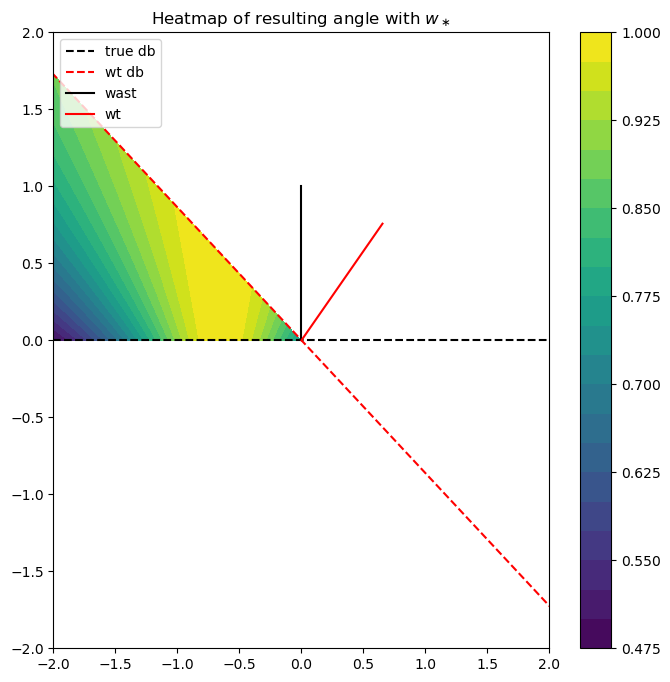

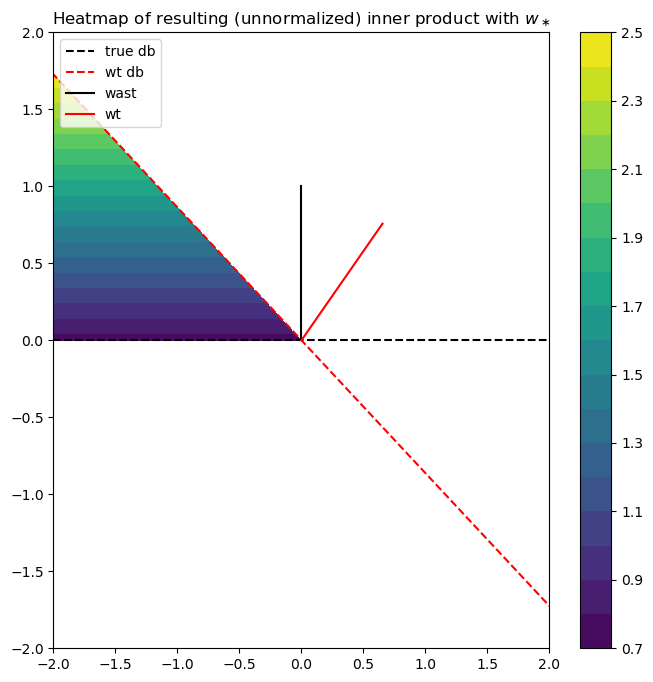

In [119]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.linspace(-2,2,11), np.zeros(11), 'k--', label='true db')
ax.plot([-100*wt[1], 100*wt[1]], [100*wt[0], -100*wt[0]], 'r--', label='wt db')
ax.plot([0, wast[0]], [0,wast[1]], 'k', label='wast')
ax.plot([0, wt[0]], [0, wt[1]], 'r', label='wt')
cs = ax.contourf(xx, yy, z, levels=20)
# ax.contour(cs, colors='k')
plt.colorbar(cs, ax=ax)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.legend(loc='upper left')
ax.set_title(r"Heatmap of resulting angle with $w_\ast$")
plt.show()

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.linspace(-2,2,11), np.zeros(11), 'k--', label='true db')
ax.plot([-100*wt[1], 100*wt[1]], [100*wt[0], -100*wt[0]], 'r--', label='wt db')
ax.plot([0, wast[0]], [0,wast[1]], 'k', label='wast')
ax.plot([0, wt[0]], [0, wt[1]], 'r', label='wt')
cs = ax.contourf(xx, yy, z2, levels=20)
# ax.contour(cs, colors='k')
plt.colorbar(cs, ax=ax)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.legend(loc='upper left')
ax.set_title(r"Heatmap of resulting (unnormalized) inner product with $w_\ast$")
plt.show()

In [213]:
from tqdm import tqdm


def run_perceptron(X, y, wstar, num_steps, method='iid', seed=42):
    n, d = X.shape
    eps = 1e-9
    rand_state = np.random.RandomState(seed)
    method_parts = method.split("-")
    if method_parts[0] == "approx":
        assert len(method_parts) == 3
        method = "-".join(method_parts[1:-1])
        if len(method_parts) < 3:
            batch_size = 20
        else:
            batch_size = int(method_parts[-1])
    
    model = Perceptron(fit_intercept=False, random_state=0)
    oracle_margin_values = np.absolute(np.inner(X, wstar))
    result = defaultdict(list)
    no_steps = 0
    for i in range(num_steps):
        if i > 0:
            # the "wrong set" -- set of indices that the current perceptron model gets incorrect
            Wt = np.where(model.predict(X) != y)[0]
            if method_parts[0] == 'approx':
                batch_inds = rand_state.choice(n, batch_size, replace=False)
                if i == 100:
                    print(batch_inds)
                incorr_inds = np.intersect1d(batch_inds, Wt)
                if incorr_inds.size == 0:
                    idx = batch_inds[0]
                    result['acc'].append(result['acc'][-1])
                    result['ip'].append(result['ip'][-1])
                    no_steps += 1
                    continue
                else:
                    Wt = incorr_inds
            
            # select idx
            if method == 'iid':
                idx = np.random.choice(Wt)
            elif method == 'margin':
                margin_values = np.absolute(np.inner(X, model.coef_.flatten()))
                idx = Wt[np.argmin(margin_values[Wt])]
            elif method == 'omargin':
                idx = Wt[np.argmin(oracle_margin_values[Wt])]
            elif method == 'maxstep':
                idx = Wt[np.argmax(oracle_margin_values[Wt])]
            elif method == 'maxangle':
                # this takes into account the normalization constant with inner product for maximizing angle
                vals = (np.inner(model.coef_.flatten(), wstar) + model.eta0*np.inner(X, wstar)) / (eps + np.linalg.norm(model.coef_.reshape(1, d) + model.eta0*X, axis=1))
                vals2 = (np.inner(model.coef_.flatten(), wstar) - model.eta0*np.inner(X, wstar)) / (eps + np.linalg.norm(model.coef_.reshape(1, d) - model.eta0*X, axis=1))
                np.maximum(vals, vals2, out=vals)
                idx = Wt[np.argmax(vals[Wt])]
            else:
                print(method)
                raise NotImplementedError()
                
        else:
            idx = i # default choice for everyone to start with same classifier
            
        model.partial_fit(X[idx,:].reshape(1,-1), [y[idx]], classes=[0,1])
        result['acc'].append(model.score(X, y))
        result['ip'].append(np.inner(model.coef_, wstar)/(np.linalg.norm(wstar)*np.linalg.norm(model.coef_)))
        
    result['no_steps'] = no_steps
    return model, result

In [214]:
n, d = 1000, 30
num_steps = 200
r = 5.
gamma = 0.01
X = r*(np.random.rand(n+100, d)-0.5)
wstar = 2.*np.random.randn(d)
mask = np.absolute(np.inner(X, wstar)) >= gamma
X = X[mask,:]
print(X.shape)
y = 1*(np.inner(X, wstar) > 0)


perceptron_results = {}
all_methods = ['iid', 'margin', 'omargin', 'maxstep', 'maxangle', 'approx-maxstep-20', 'approx-maxangle-20',\
              'approx-iid-20', 'approx-margin-20', 'approx-omargin-20']
for method in tqdm(all_methods, total=len(all_methods)):
    ptron, res_dict = run_perceptron(X, y, wstar, num_steps=num_steps, method=method)
    perceptron_results[method] = {'model' : ptron, 'results': res_dict}

(1100, 30)


 60%|████████████████████████████████████████████████████████████████████▍                                             | 6/10 [00:01<00:01,  3.06it/s]

[ 250  912 1025  305  829  467  289  763  923  121  645 1090 1072 1043
  438  138  843  197   33  654]


 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 7/10 [00:02<00:00,  3.00it/s]

[ 250  912 1025  305  829  467  289  763  923  121  645 1090 1072 1043
  438  138  843  197   33  654]


 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 8/10 [00:02<00:00,  3.10it/s]

[ 250  912 1025  305  829  467  289  763  923  121  645 1090 1072 1043
  438  138  843  197   33  654]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9/10 [00:02<00:00,  3.21it/s]

[ 250  912 1025  305  829  467  289  763  923  121  645 1090 1072 1043
  438  138  843  197   33  654]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.13it/s]

[ 250  912 1025  305  829  467  289  763  923  121  645 1090 1072 1043
  438  138  843  197   33  654]


In [208]:
for method, d in perceptron_results.items():
    print(method, d['results']['acc'][-1], d['results']['no_steps'])

iid 0.9209090909090909 0
margin 0.9127272727272727 0
omargin 0.5545454545454546 0
maxstep 0.9727272727272728 0
maxangle 0.9645454545454546 0
approx-maxstep-20 0.9418181818181818 22
approx-maxangle-20 0.9436363636363636 23
approx-iid-20 0.9254545454545454 11
approx-margin-20 0.9281818181818182 26
approx-omargin-20 0.7827272727272727 0


In [209]:
for method, d in perceptron_results.items():
    if method.split('-')[0] == 'approx':
        print(method, d['results']['no_steps'], np.round(d['results']['acc'][-20:], 4) )

approx-maxstep-20 22 [0.9255 0.9136 0.9191 0.9255 0.9209 0.9209 0.9327 0.9373 0.9373 0.9373
 0.9327 0.9318 0.93   0.9418 0.9418 0.9473 0.9473 0.9427 0.9436 0.9418]
approx-maxangle-20 23 [0.9309 0.9309 0.9309 0.9364 0.9364 0.9364 0.9373 0.9436 0.9345 0.9336
 0.9391 0.9409 0.9455 0.94   0.9291 0.9409 0.9318 0.9373 0.9345 0.9436]
approx-iid-20 11 [0.9027 0.8991 0.9064 0.9091 0.9109 0.91   0.9136 0.9073 0.9109 0.9073
 0.9236 0.93   0.9273 0.9336 0.9309 0.9345 0.9264 0.9255 0.9227 0.9255]
approx-margin-20 26 [0.9236 0.9182 0.9182 0.9118 0.9073 0.9073 0.9209 0.9309 0.9155 0.9155
 0.92   0.9345 0.9455 0.9455 0.9455 0.9336 0.9309 0.9309 0.9291 0.9282]
approx-omargin-20 0 [0.78   0.7745 0.79   0.7864 0.7855 0.7873 0.7855 0.7909 0.7664 0.77
 0.7764 0.7764 0.7709 0.77   0.7773 0.7836 0.7682 0.7691 0.7727 0.7827]


------ True Values ------


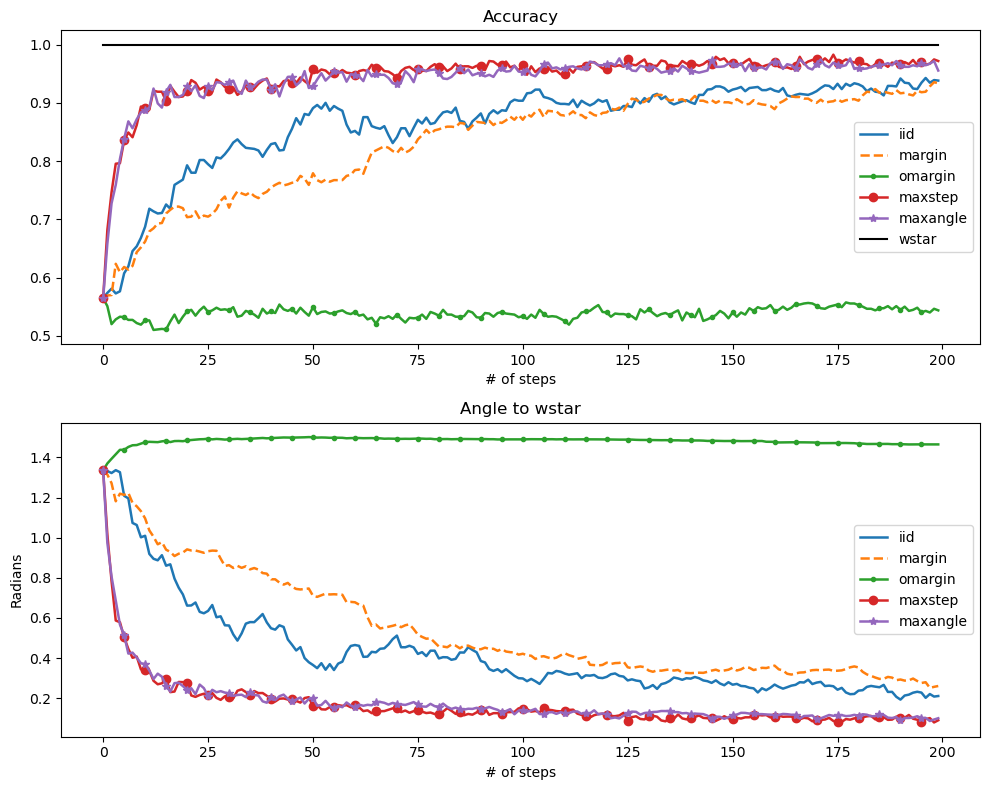

------ Approx Values  (i.e., take batches) ------


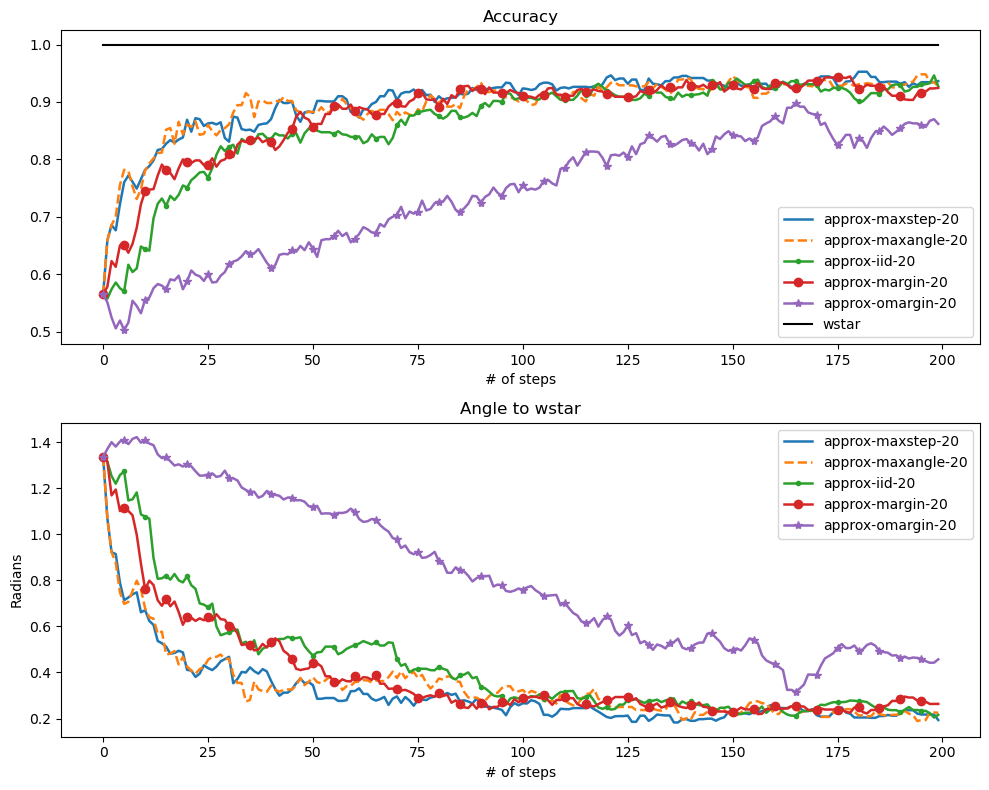

In [402]:
print("------ True Values ------")
plot_acc_angle(perceptron_results, 1.0)

print("------ Approx Values  (i.e., take batches) ------")
plot_acc_angle(perceptron_results, 1.0, True)

Seems that ``maxstep`` and ``maxangle`` perform about on par with eachother in this experiment. Perhaps the "greediness" in ``maxstep`` isn't too bad since you still are taking steps on well-behaved points (under this linear model). I would think this would not do as well in the more complicated data settings because those maximizers in the "wrong set" could be outliers.

I think something is wrong with maxangle, shouldn't it always be better than maxstep, by virtue of me setting the batch inds to be the same in each iteration?

# Logistic Regression


We now run Logistic Regression, where we introduce the ``maxsteplr`` policy according to corresponding SGD update:
$$
    w_{t+1} = w_t + \sigma(-y_i x_i \cdot w_t)y_i x_i,
$$
which gives as an updated inner product with the oracle $w_\ast$ as
$$
\begin{align*}
    w_{t+1} \cdot w_\ast &= w_t \cdot w_\ast + \sigma(-y_i x_i \cdot w_t) y_i x_i \cdot w_\ast \\
    &= w_t \cdot w_\ast + \sigma(-y_i x_i \cdot w_t)\begin{cases} 
             |x_i \cdot w_\ast| & \text{ if } y_i = sign(x_i \cdot w_\ast) \\
             -|x_i \cdot w_\ast| & \text{ if } y_i \not= sign(x_i \cdot w_\ast) \\
            \end{cases},
\end{align*}
$$
which suggests choosing $x_i, y_i$ that maximize the quantity
$$
    \sigma(-y_i x_i \cdot w_t) |x_i \cdot w_\ast|,
$$
subject to the constraint that $w_\ast$ classifies $x_i$ correctly (i.e., $y_i x_i \cdot w_\ast > 0$).


__As a reminder: We do the sampling of all methods over the "wrong set", $\mathcal{W}_t$, for more fair comparison.__
* For example, ``iid`` in the below examples are iid sampling __over $\mathcal{W}_t = \{(x,y) \in \mathcal{D} : f_t(x) \not= y \}$. 
* We also find that, in the non-separable case, we can simply ignore the data pairs that the oracle model gets incorrect; i.e., we restrict $\mathcal{W}_t$ further as 
$$
    \mathcal{W}_t := \{(x,y) \in \mathcal{D} : f_t(x) \not= y \text{ and } f_\ast(x) = y \}.
$$
This ensures that points which are very far from the decision boundary and were labeled "incorrectly" don't mess up the methods. This "cheating" is allowed because we are assuming access to the teacher model (oracle) which can identify what points wouldn't be useful for training on -- we can ignore these points. 

In [463]:
from sklearn.linear_model import SGDClassifier


def sigmoid(z):
    return 1./(1. + np.exp(-z))

def run_logistic_regression(X, y, wstar, num_steps, method='iid', seed=42, record_choices=False):
    n, d = X.shape
    eps = 1e-9
    rand_state = np.random.RandomState(seed)
    method_parts = method.split("-")
    if method_parts[0] == "approx":
        assert len(method_parts) == 3
        method = "-".join(method_parts[1:-1])
        if len(method_parts) < 3:
            batch_size = 20
        else:
            batch_size = int(method_parts[-1])
    
    model = SGDClassifier(loss='log_loss', penalty=None, fit_intercept=False, random_state=0)
    
    oracle_margin_values = np.absolute(np.inner(X, wstar))
    oracle_margin_values[(2.*y-1.0) != np.sign(np.inner(X, wstar))] *= -1.0 # identify the points that are wrongly classified by the oracle
    result = defaultdict(list)
    no_steps = 0
    for i in range(num_steps):
        if i > 0:
            wt = model.coef_.flatten().copy()
            # the "wrong set" -- set of indices that the current perceptron model gets incorrect (and the teacher model gets correct)
            Wt = np.where(((model.predict(X) != y)*(oracle_margin_values >= 0.0)))[0]
            result['Wt_size'].append(Wt.size)
            idx = None
            if method_parts[0] == 'approx':
                batch_inds = rand_state.choice(n, batch_size, replace=False)
                incorr_inds = np.intersect1d(batch_inds, Wt)
                if incorr_inds.size == 0:
                    idx = batch_inds[0]
                    
                else:
                    Wt = incorr_inds
            
            if Wt.size == 0:
                result['Wt_size'].append(0)
                break
            
            if idx is None:
                # select idx
                if method == 'iid':
                    idx = np.random.choice(Wt)
                elif method == 'margin':
                    margin_values = np.absolute(np.inner(X, wt))
                    idx = Wt[np.argmin(margin_values[Wt])]
                elif method == 'omargin':
                    idx = Wt[np.argmin(oracle_margin_values[Wt])]
                elif method == 'maxstep':
                    idx = Wt[np.argmax(oracle_margin_values[Wt])]
                elif method == 'maxsteplr':
                    vals = sigmoid(-(2.*y[Wt] - 1.0)*model.predict_proba(X)[Wt,1])
                    idx = Wt[np.argmax(vals*oracle_margin_values[Wt])]
                elif method == 'maxangle':
                    # this takes into account the normalization constant with inner product for maximizing angle
                    vals = (np.inner(wt, wstar) + model.eta0*np.inner(X, wstar)) / (eps + np.linalg.norm(wt.reshape(1, d) + model.eta0*X, axis=1))
                    vals2 = (np.inner(wt, wstar) - model.eta0*np.inner(X, wstar)) / (eps + np.linalg.norm(wt.reshape(1, d) - model.eta0*X, axis=1))
                    np.maximum(vals, vals2, out=vals)
                    idx = Wt[np.argmax(vals[Wt])]
                else:
                    print(method)
                    raise NotImplementedError()
                
        else:
            idx = i # default choice for everyone to start with same classifier
            wt = np.zeros(d)
            Wt = np.arange(n)
            result['Wt_size'].append(n)
        
            
        model.partial_fit(X[idx,:].reshape(1,-1), [y[idx]], classes=[0,1])
        
        result['acc'].append(model.score(X, y))
        result['ip'].append(np.inner(model.coef_, wstar)/(np.linalg.norm(wstar)*np.linalg.norm(model.coef_)))
        result['delta_wt'].append(np.linalg.norm(wt - model.coef_.flatten()))
        result['wt_norm'].append(np.linalg.norm(model.coef_.flatten()))
        
        if record_choices:
            result['choices'].append(idx)
    
    return model, result


In [445]:
n, d = 1000, 30
num_steps = 200
r = 5.
gamma = 0.01
X = r*(np.random.rand(n+100, d)-0.5)
wstar = 2.*np.random.randn(d)
mask = np.absolute(np.inner(X, wstar)) >= gamma
X = X[mask,:]
print(X.shape)

y = 1*(np.inner(X, wstar) > 0)
Wstar = np.where((1.*(X @ wstar)>= 0.0) != y)[0]
Wstar_exp = np.array([])



logregression_results = {}
all_methods = sorted(['iid', 'margin', 'omargin', 'maxstep', 'approx-maxstep-20', \
              'approx-iid-20', 'approx-margin-20', 'approx-omargin-20', 'maxsteplr', 'approx-maxsteplr-20'])
for method in tqdm(all_methods, total=len(all_methods)):
    LR, res_dict = run_logistic_regression(X, y, wstar, num_steps=num_steps, method=method)
    logregression_results[method] = {'model' : LR, 'results': res_dict}


(1099, 30)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.05it/s]


In [446]:
for method, d in logregression_results.items():
    print(method, np.round(d['results']['acc'][-1], 4) )

approx-iid-20 0.9172
approx-margin-20 0.9472
approx-maxstep-20 0.95
approx-maxsteplr-20 0.9572
approx-omargin-20 0.8608
iid 0.9399
margin 0.9509
maxstep 0.9745
maxsteplr 0.9745
omargin 0.5396


In [447]:
for method, d in logregression_results.items():
    print(method, np.round(d['results']['acc'][-1], 4) )

approx-iid-20 0.9172
approx-margin-20 0.9472
approx-maxstep-20 0.95
approx-maxsteplr-20 0.9572
approx-omargin-20 0.8608
iid 0.9399
margin 0.9509
maxstep 0.9745
maxsteplr 0.9745
omargin 0.5396


------ True Values ------


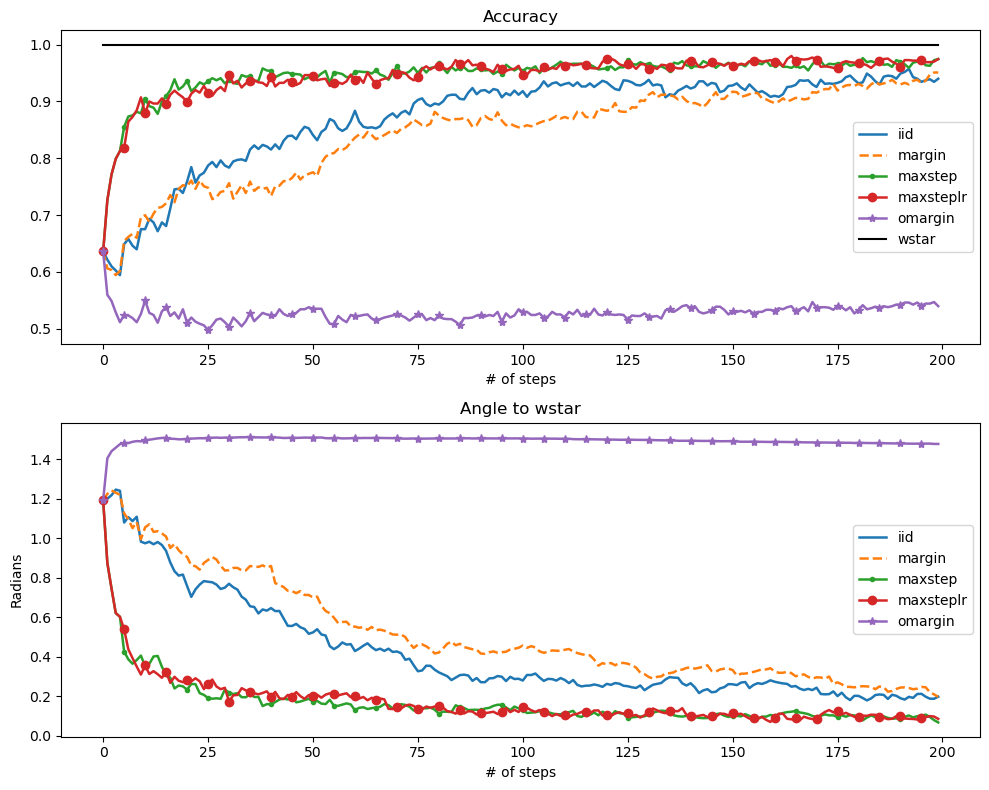

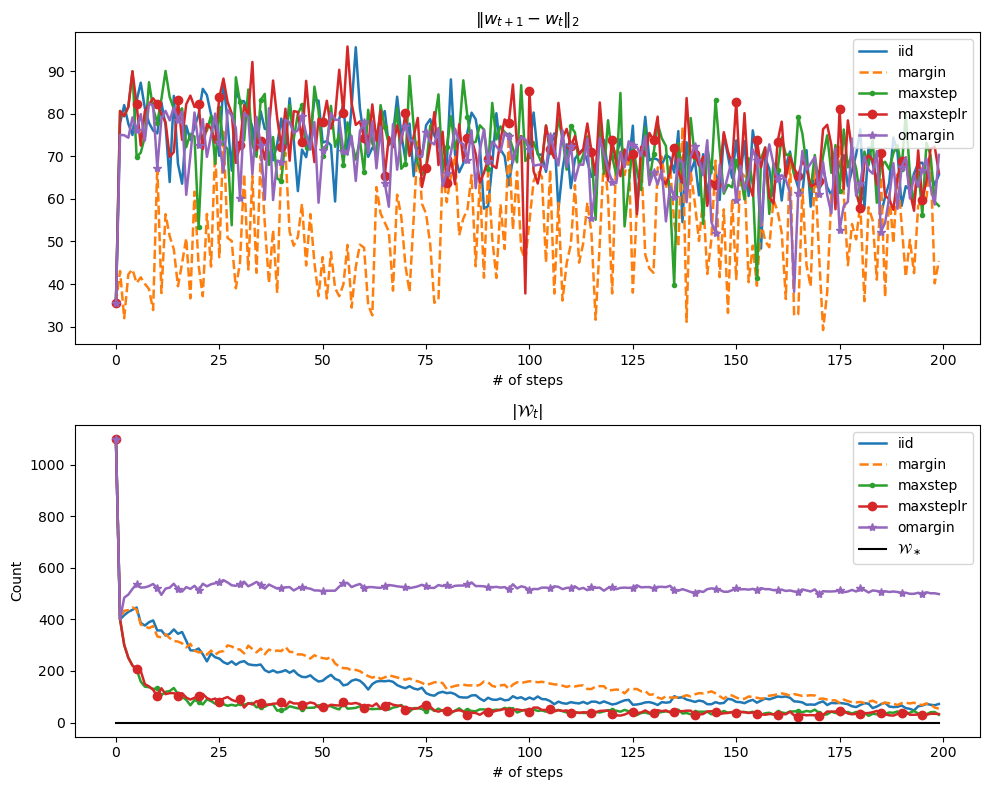

------ Approx Values  (i.e., take batches) ------


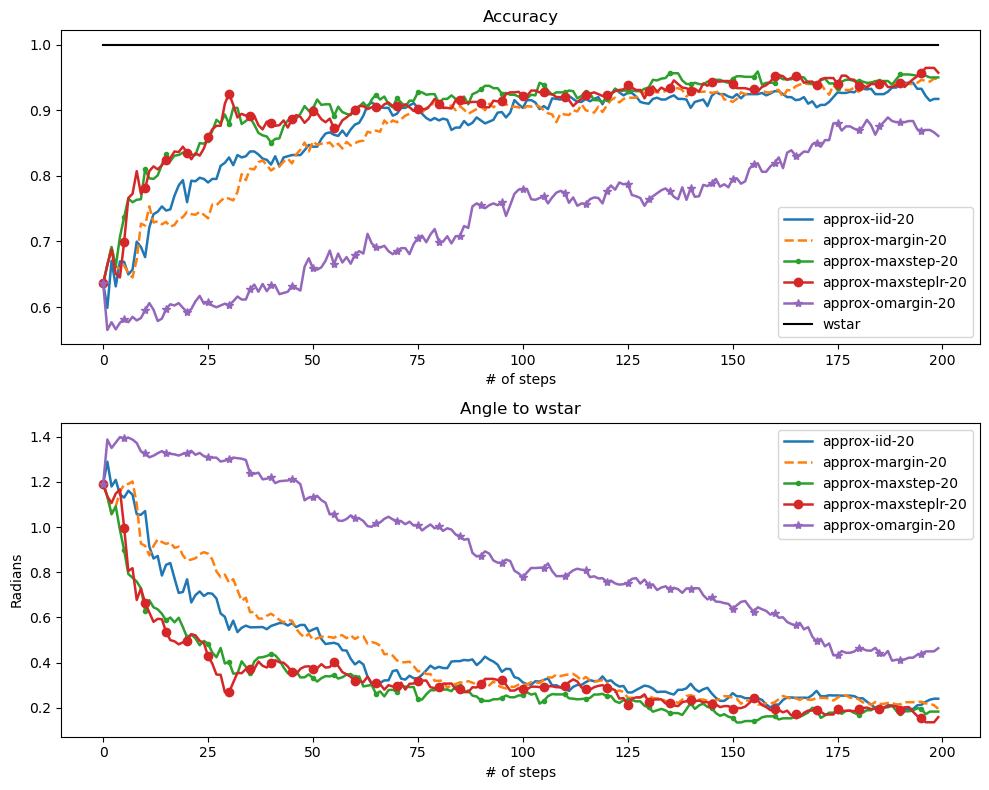

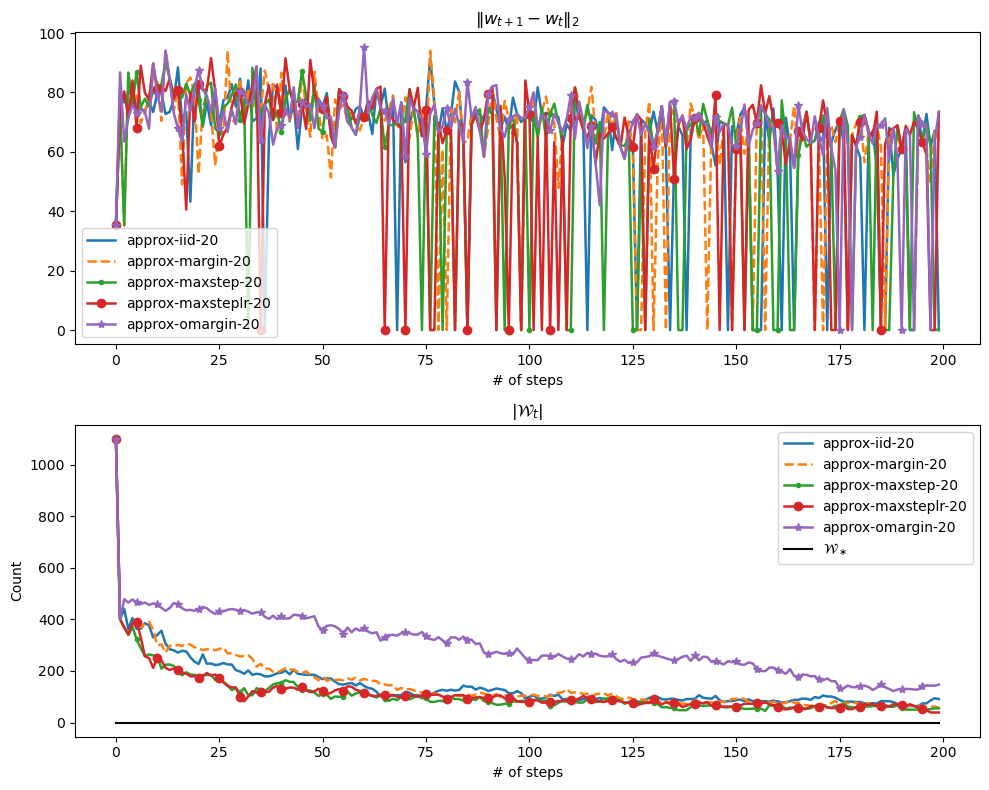

In [448]:
print("------ True Values ------")
plot_acc_angle(logregression_results, 1.-Wstar.size/float(n), approx=False)
plot_diff_size(logregression_results, Wstar.size)

print("------ Approx Values  (i.e., take batches) ------")
plot_acc_angle(logregression_results, 1.-Wstar.size/float(n), approx=True)
plot_diff_size(logregression_results, Wstar.size, True)

Similar behavior here with Logistic Regression -- we train faster earlier on by focusing on those points that the current classifier "gets wrong", but the oracle has largest margin (i.e., most confident to train on). Let's see how the extension to the non-separable case goes:

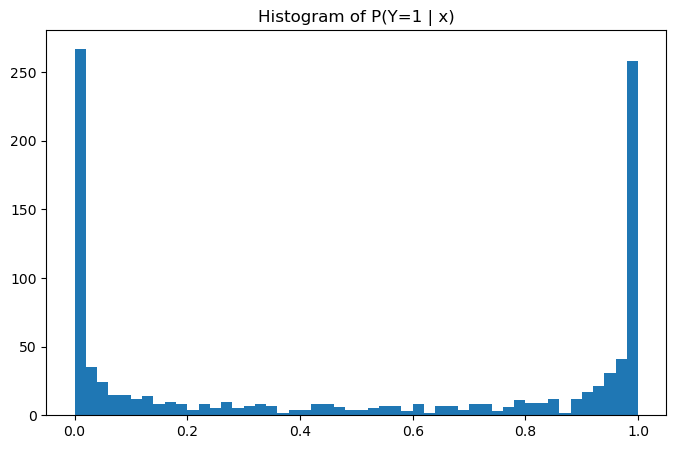

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.84it/s]


In [449]:
n, d = 1000, 30
num_steps = 200
r = 5.
X = r*(np.random.rand(n, d)-0.5)
wstar = 2.*np.random.randn(d)
eta = sigmoid(0.5*X @ wstar)

rand_state = np.random.RandomState(43)

if d == 2:
    fig, ax = plt.subplots(figsize=(8,5))
    p =ax.scatter(X[:,0], X[:,1], c=eta)
    plt.colorbar(p, ax=ax)
    plt.show()

fig, ax = plt.subplots(figsize=(8,5))
ax.hist(eta, bins=50)
ax.set_title("Histogram of P(Y=1 | x)")
plt.show()



run = True
if run:
    y = 1.*(rand_state.rand(n) <= eta)
    Wstar = np.where((1.*(X @ wstar)>= 0.0) != y)[0]
    Wstar_exp = np.where((eta >= 0.5) != y)[0]


    logregression_noisy_results = {}
    all_methods = sorted(['iid', 'margin', 'omargin', 'maxstep', 'approx-maxstep-20', \
                  'approx-iid-20', 'approx-margin-20', 'approx-omargin-20', 'maxsteplr', 'approx-maxsteplr-20'])
    for method in tqdm(all_methods, total=len(all_methods)):
        LR, res_dict = run_logistic_regression(X, y, wstar, num_steps=num_steps, method=method)
        logregression_noisy_results[method] = {'model' : LR, 'results': res_dict}


In [450]:
for method, d in logregression_noisy_results.items():
    print(method, np.round(d['results']['acc'][-1], 4) )

approx-iid-20 0.894
approx-margin-20 0.903
approx-maxstep-20 0.906
approx-maxsteplr-20 0.898
approx-omargin-20 0.876
iid 0.906
margin 0.9
maxstep 0.907
maxsteplr 0.911
omargin 0.6


------ True Values ------


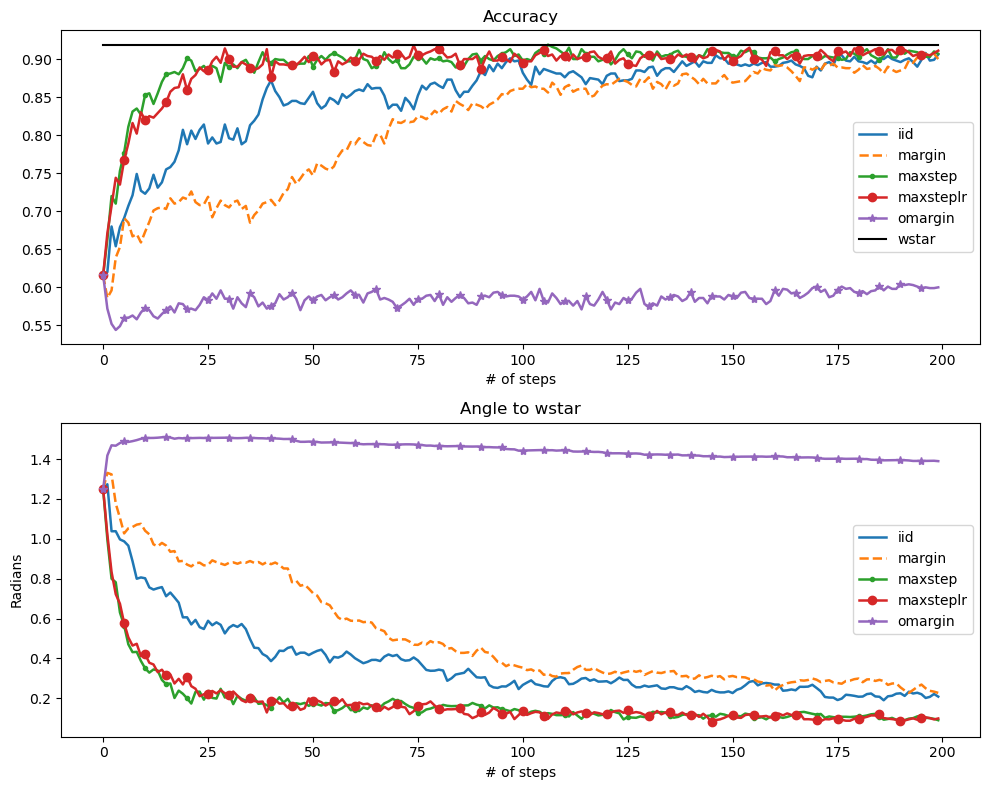

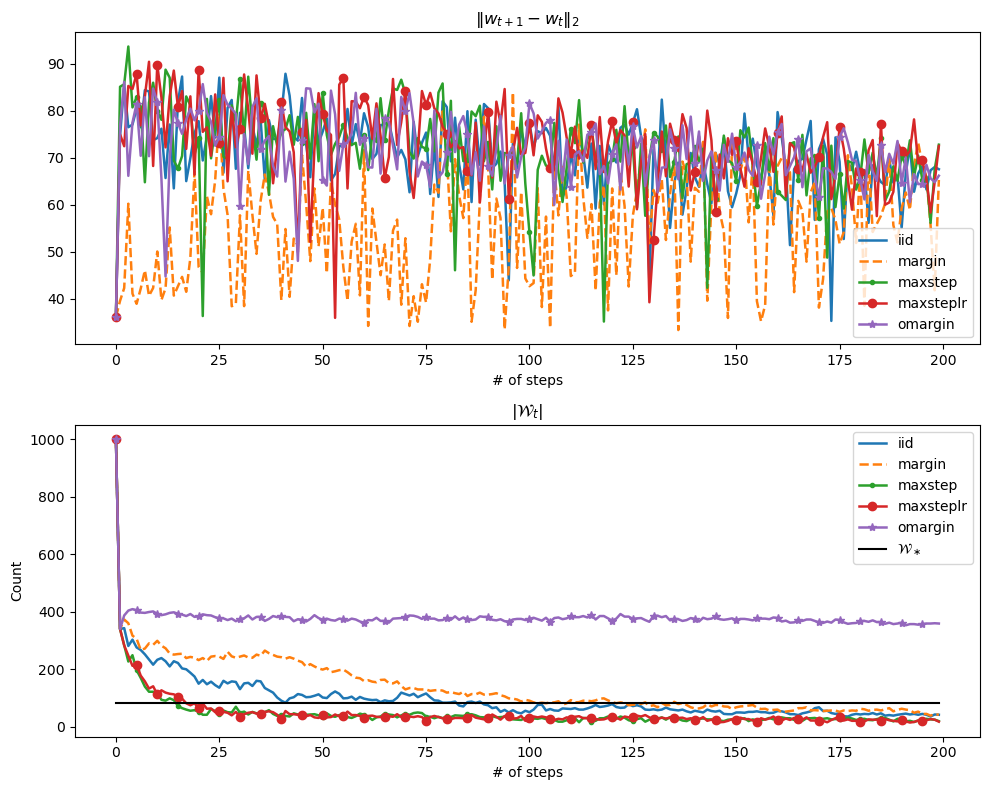

------ Approx Values  (i.e., take batches) ------


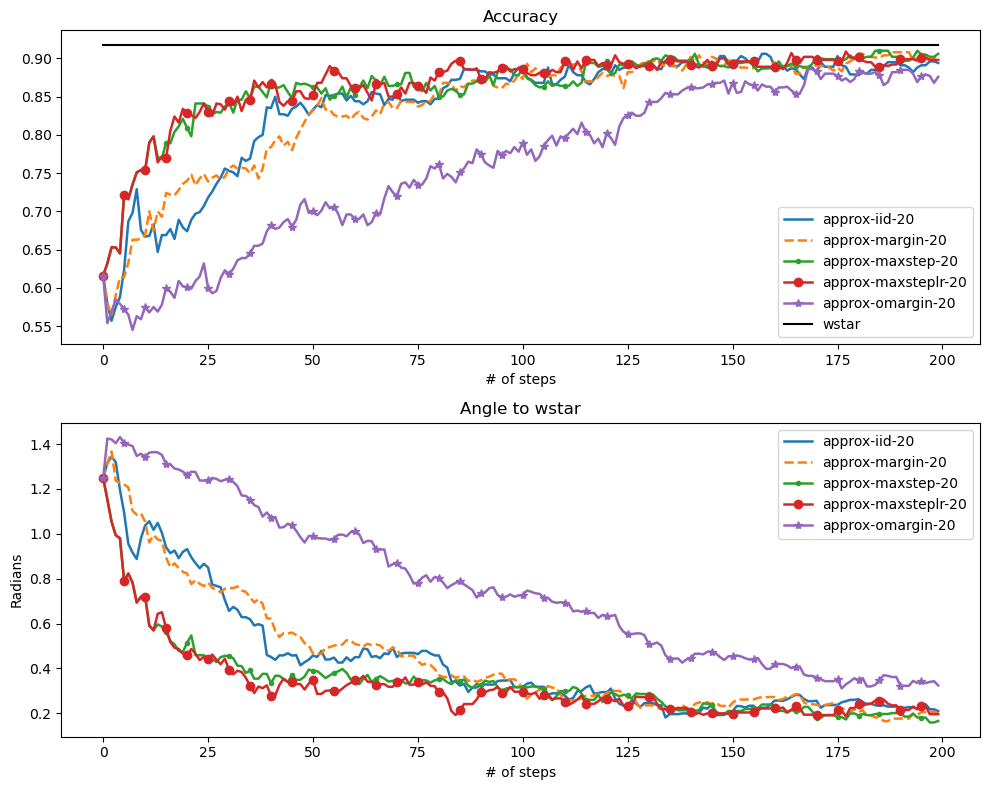

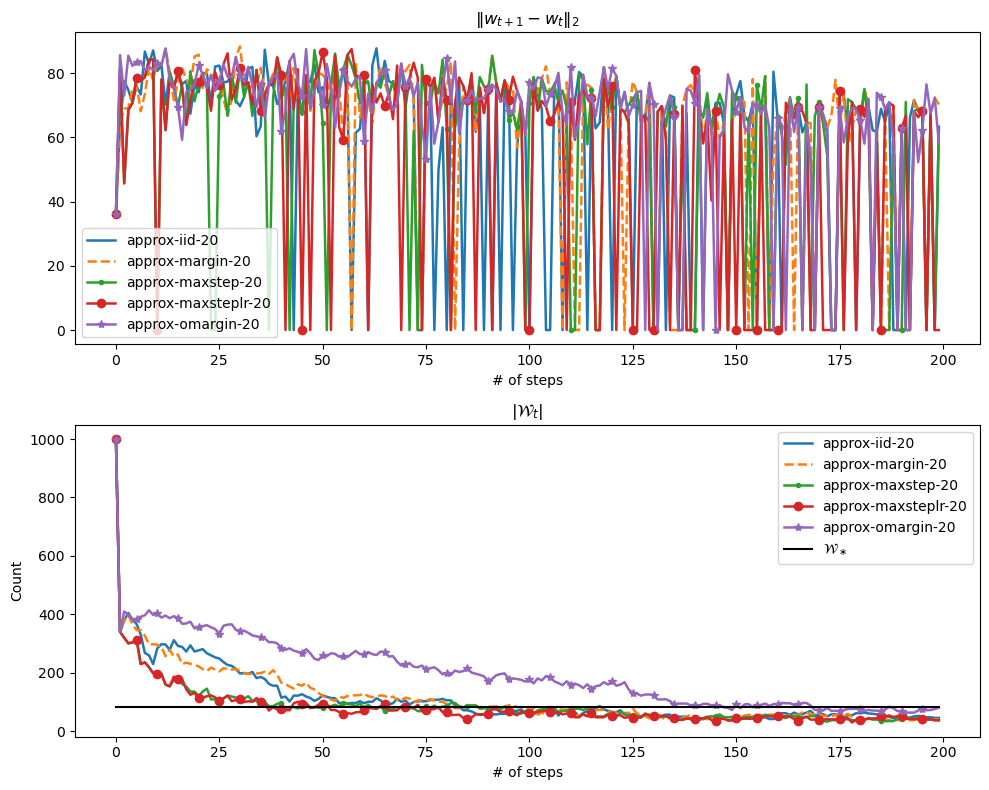

In [452]:
print("------ True Values ------")
plot_acc_angle(logregression_noisy_results, 1.-Wstar_exp.size/float(n), approx=False)
plot_diff_size(logregression_noisy_results, Wstar_exp.size)

print("------ Approx Values  (i.e., take batches) ------")
plot_acc_angle(logregression_noisy_results, 1.-Wstar_exp.size/float(n), approx=True)
plot_diff_size(logregression_noisy_results, Wstar_exp.size, True)

## 2 dimensional example

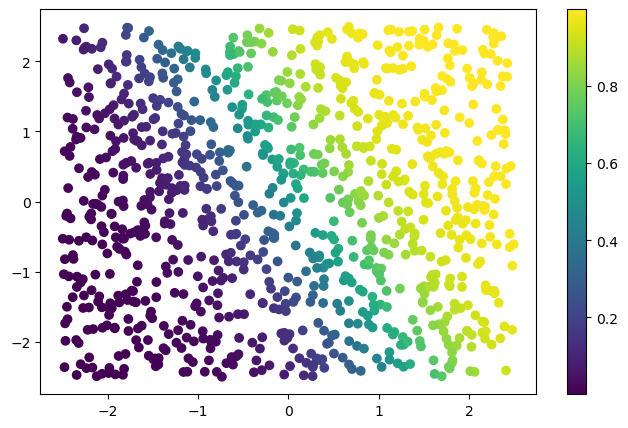

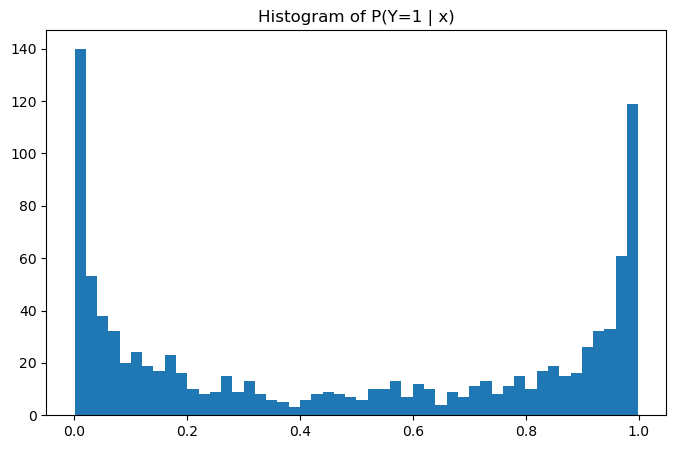

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


In [472]:
n, d = 1000, 2
num_steps = 200
r = 5.
X = r*(np.random.rand(n, d)-0.5)
wstar = 2.*np.random.randn(d)
eta = sigmoid(X @ wstar)
rand_state = np.random.RandomState(43)

if d == 2:
    fig, ax = plt.subplots(figsize=(8,5))
    p =ax.scatter(X[:,0], X[:,1], c=eta)
    plt.colorbar(p, ax=ax)
    plt.show()

fig, ax = plt.subplots(figsize=(8,5))
ax.hist(eta, bins=50)
ax.set_title("Histogram of P(Y=1 | x)")
plt.show()



run = True
if run:
    y = 1.*(rand_state.rand(n) <= eta)
    Wstar = np.where((1.*(X @ wstar)>= 0.0) != y)[0]
    Wstar_exp = np.where((eta >= 0.5) != y)[0]
    logregression_noisy2_results = {}
    all_methods = sorted(['iid', 'margin', 'omargin', 'maxstep', 'approx-maxstep-20', \
                  'approx-iid-20', 'approx-margin-20', 'approx-omargin-20', 'maxsteplr', 'approx-maxsteplr-20'])
    for method in tqdm(all_methods, total=len(all_methods)):
        LR, res_dict = run_logistic_regression(X, y, wstar, num_steps=num_steps, method=method, record_choices=True)
        logregression_noisy2_results[method] = {'model' : LR, 'results': res_dict}


In [473]:
for method, d in logregression_noisy2_results.items():
    print(method, np.round(d['results']['acc'][-1], 4) )

approx-iid-20 0.85
approx-margin-20 0.85
approx-maxstep-20 0.85
approx-maxsteplr-20 0.832
approx-omargin-20 0.85
iid 0.85
margin 0.85
maxstep 0.85
maxsteplr 0.85
omargin 0.85


------ True Values ------


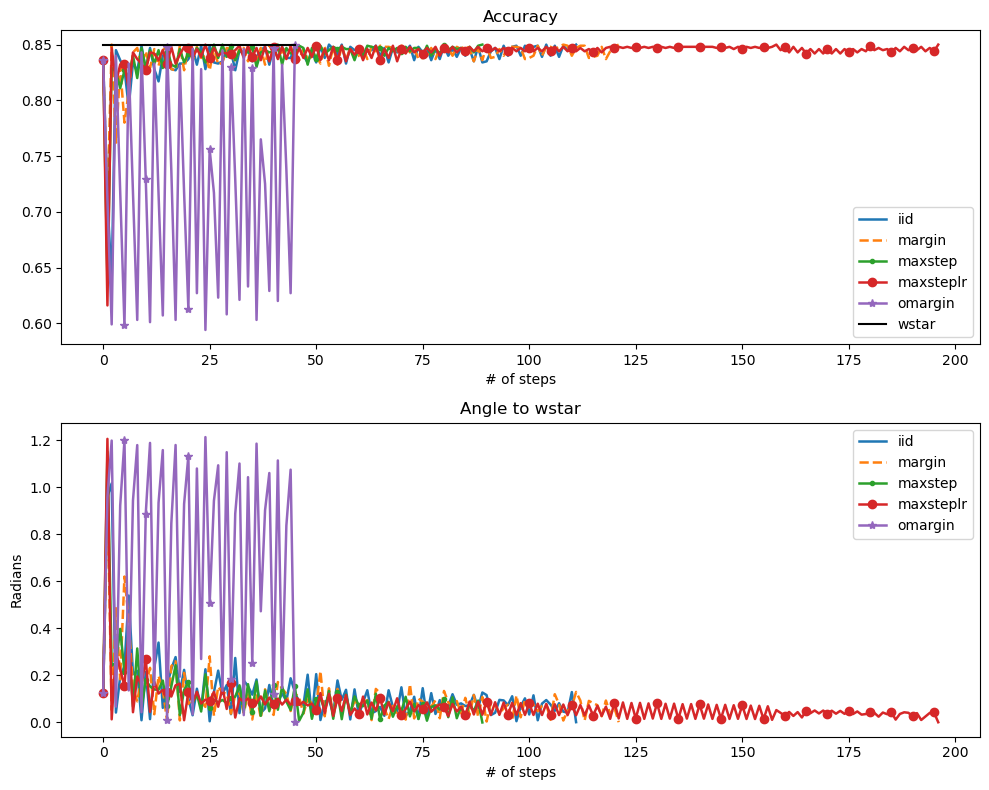

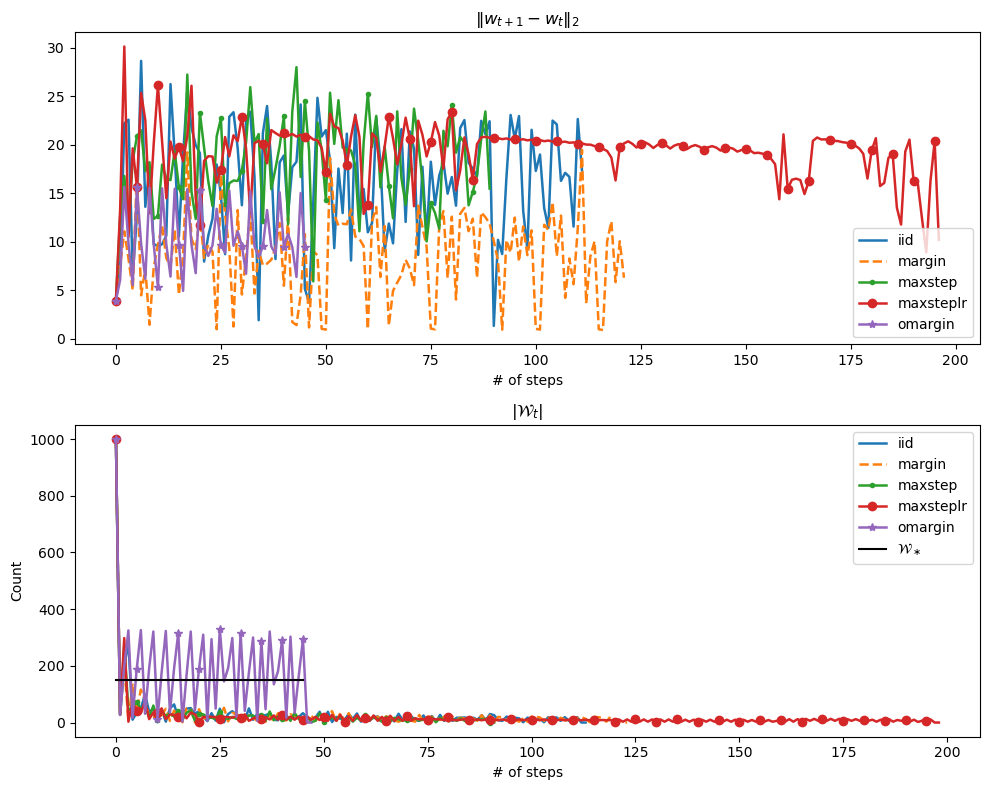

------ Approx Values  (i.e., take batches) ------


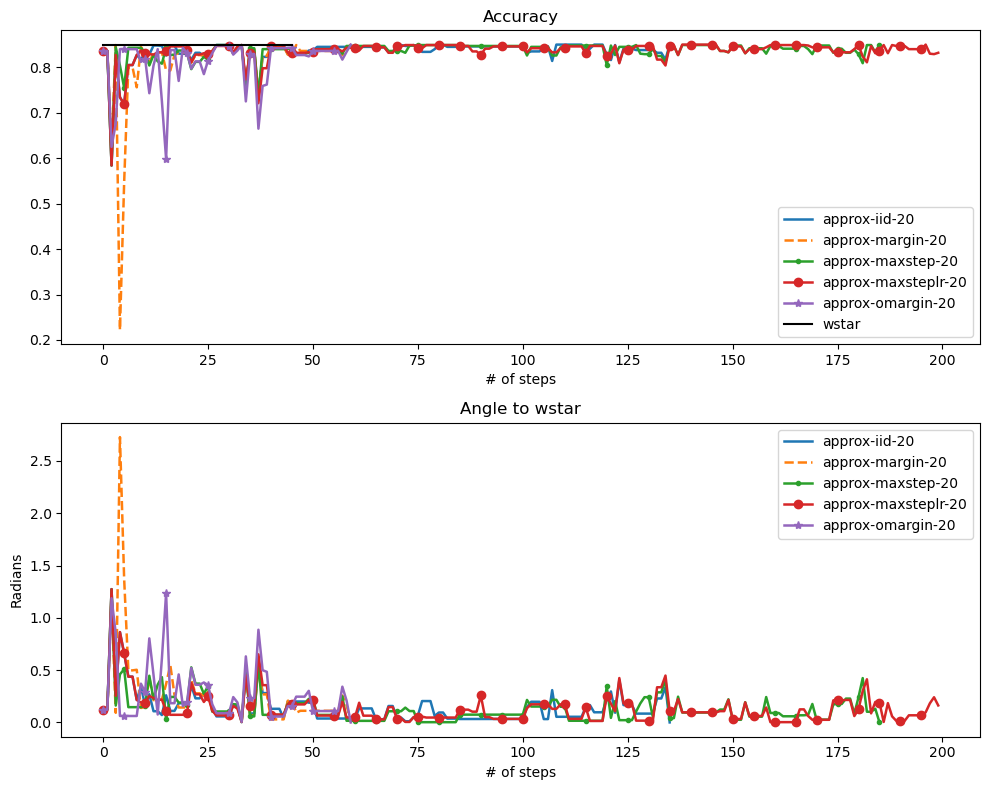

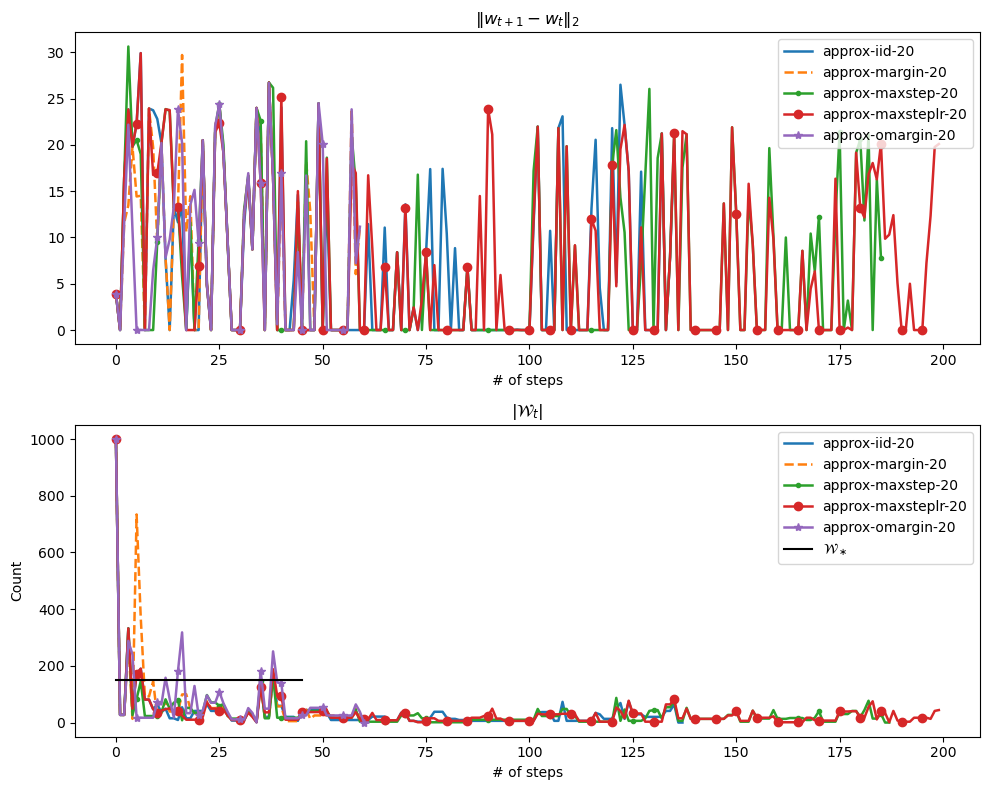

In [474]:
print("------ True Values ------")
plot_acc_angle(logregression_noisy2_results, 1.-Wstar.size/float(n), approx=False)
plot_diff_size(logregression_noisy2_results, Wstar.size)

print("------ Approx Values  (i.e., take batches) ------")
plot_acc_angle(logregression_noisy2_results, 1.-Wstar.size/float(n), approx=True)
plot_diff_size(logregression_noisy2_results, Wstar.size, True)

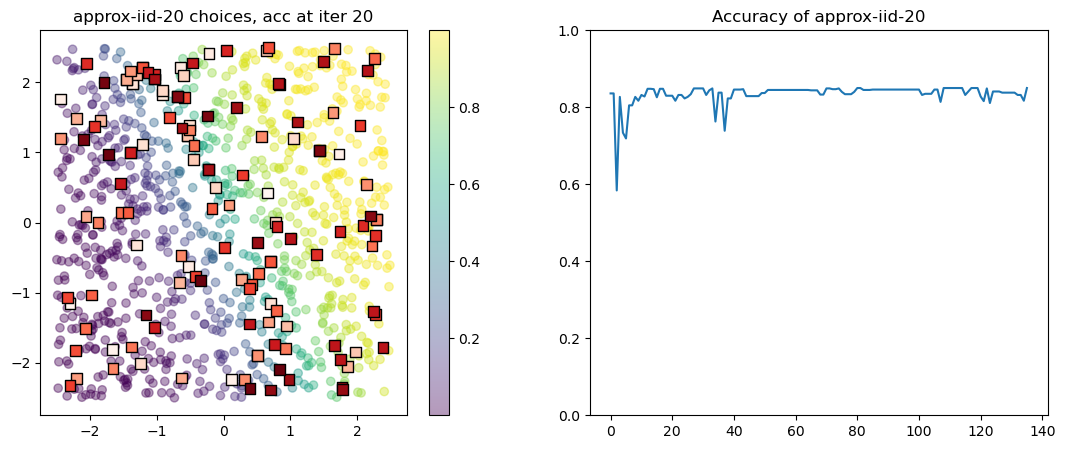

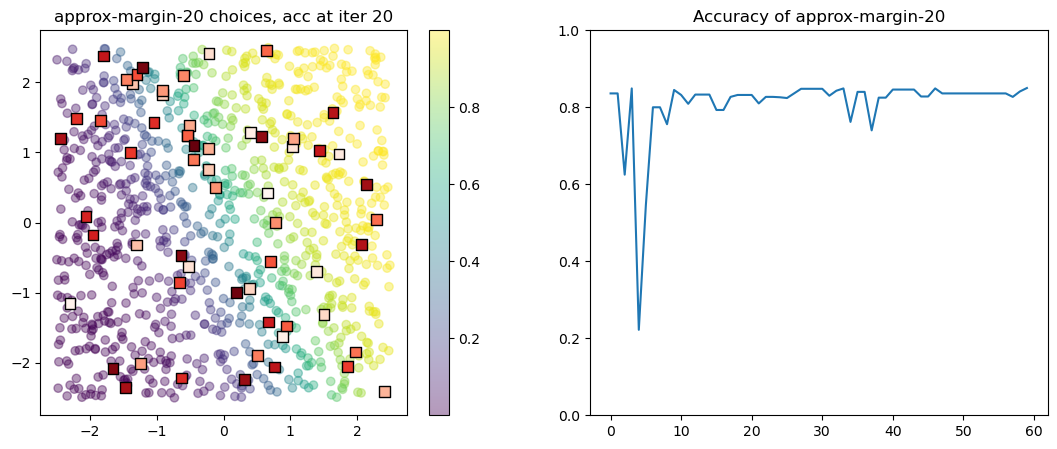

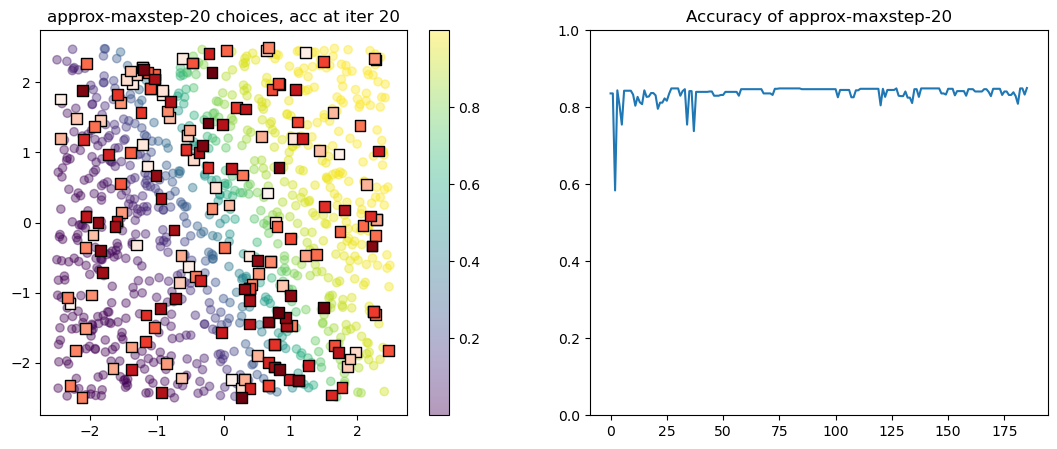

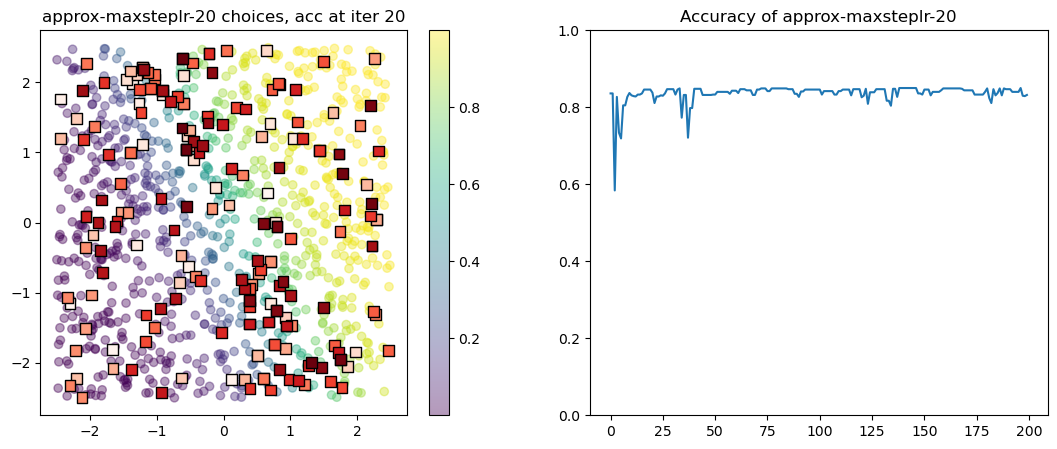

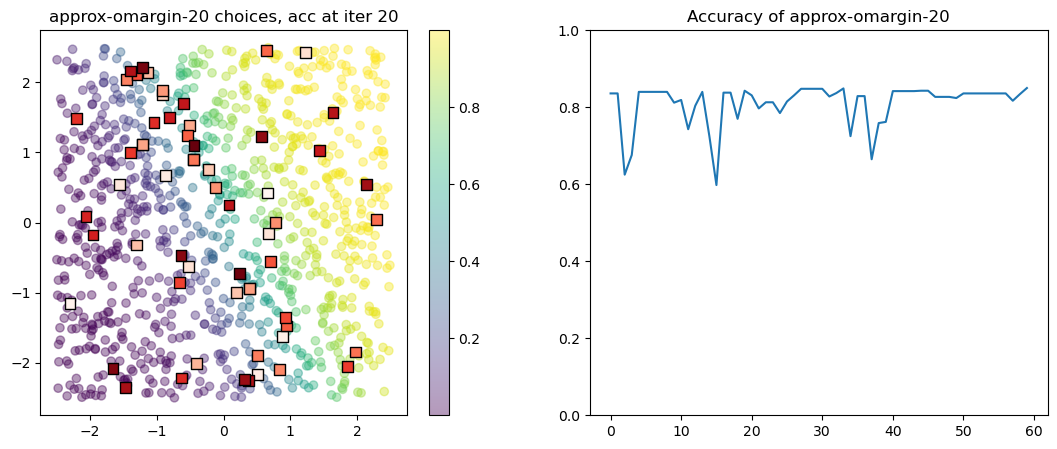

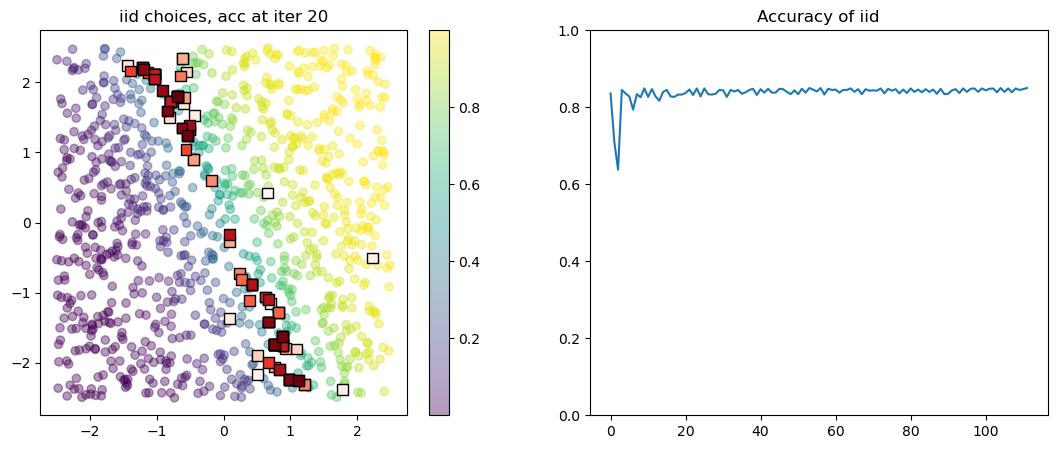

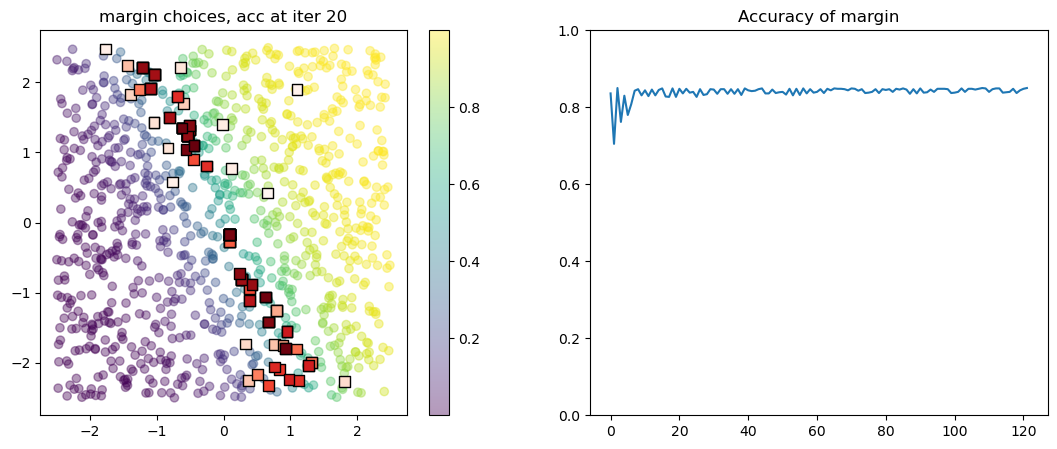

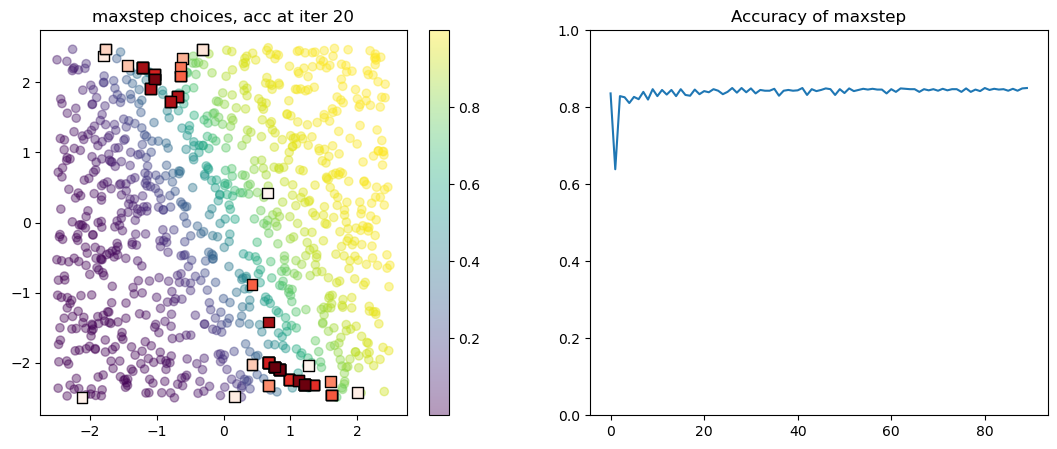

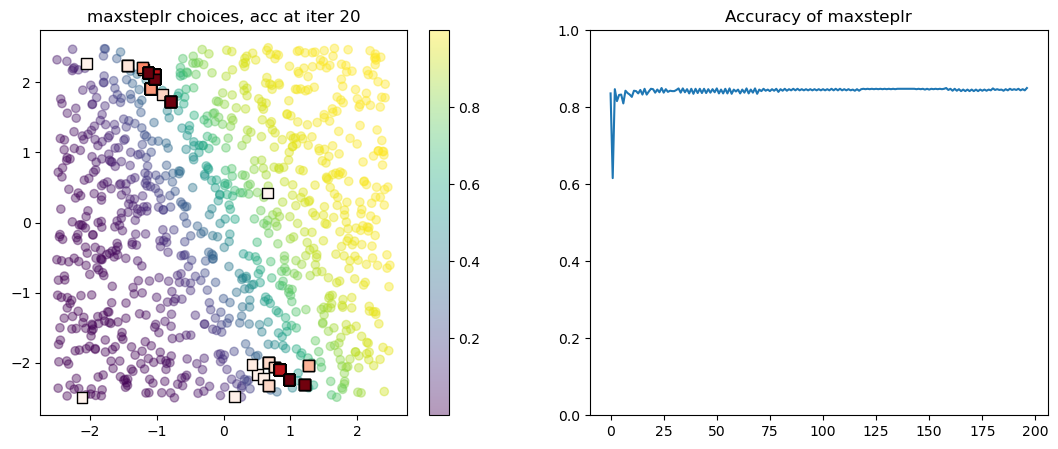

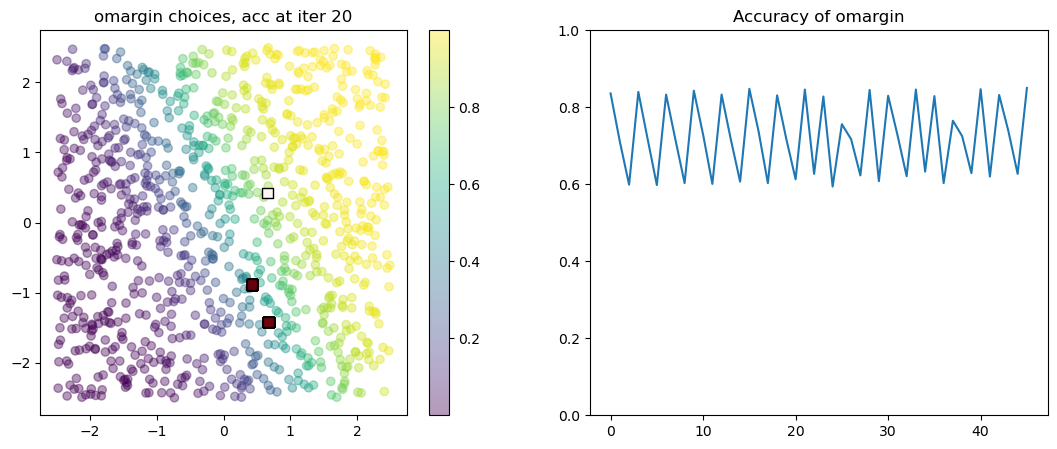

In [475]:
for method, d in sorted(logregression_noisy2_results.items()):
    fig, axs = plt.subplots(1, 2, figsize=(13,5))
    p =axs[0].scatter(X[:,0], X[:,1], c=eta, alpha=0.4)
    choices = d['results']['choices']
    axs[0].scatter(X[choices,0], X[choices,1], c=np.arange(len(choices)), cmap='Reds', marker='s', s=60, edgecolor='k')
    plt.colorbar(p, ax=axs[0])
    axs[0].set_title(f"{method} choices, acc at iter 20")
    axs[1].plot(range(len(d['results']['acc'])), d['results']['acc'], label='acc')
    axs[1].set_ylim(0,1)
#     axs[1].plot(range(num_steps), d['results']['delta_wt'], label='delta_wt')
#     axs[1].plot(range(num_steps), d['results']['Wt_size'], label='Wt_size')
#     axs[1].legend()
#     axs[1].set_ylim(0,100)
    axs[1].set_title(f"Accuracy of {method}")
    plt.show()
